# SNR finder ANN model training

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from ler.utils import add_dict_values, append_json, get_param_from_json, load_json, save_json
import tensorflow as tf

import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.models import load_model

from gwsnr import antenna_response_array, cubic_spline_interpolator2d

In [4]:
# # Uncomment to generate new data to test the model

# # generating astrophysical data for testing using `ler` package
# from ler.rates import LeR
# from ler.utils import get_param_from_json

# ler = LeR(
#     npool=8,
#     z_max=10,  # becareful with this value
#     spin_zero=False,
#     spin_precession=True,
#     verbose=False,
#     mtot_max=500,
#     minimum_frequency=10,
#     waveform_approximant='IMRPhenomXPHM',
#     snr_type='inner_product',
#     ifos=['ET', 'CE'],
# )

# size_ = 50000
# ler.batch_size = 50000
# ler.unlensed_cbc_statistics(size=size_, output_jsonfile='unlensed_param_testing_ETCE.json', resume=True);

In [5]:
# let's generate IMRPhenomD (spinless) interpolartor for the snr_half (refer to gwsnr documentation)
# One of the training input is half_snr
from gwsnr import GWSNR
gwsnr = GWSNR(snr_type='interpolation',
    mtot_max=500,
    minimum_frequency=10,
    waveform_approximant='IMRPhenomD',
    ifos=['ET', 'CE']
)

Interpolator will be generated for ET1 detector at ./interpolator_pickle/ET1/partialSNR_dict_1.pickle
Interpolator will be generated for ET2 detector at ./interpolator_pickle/ET2/partialSNR_dict_1.pickle
Interpolator will be generated for ET3 detector at ./interpolator_pickle/ET3/partialSNR_dict_1.pickle
Interpolator will be generated for CE detector at ./interpolator_pickle/CE/partialSNR_dict_1.pickle
Please be patient while the interpolator is generated
Generating interpolator for ['ET1', 'ET2', 'ET3', 'CE'] detectors


interpolation for each mass_ratios: 100%|███████████████████████████| 50/50 [03:31<00:00,  4.24s/it]


Chosen GWSNR initialization parameters:

npool:  4
snr type:  interpolation
waveform approximant:  IMRPhenomD
sampling frequency:  2048.0
minimum frequency (fmin):  10
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=10): 369.97199706893525
detectors:  ['ET1', 'ET2', 'ET3', 'CE']
psds:  [PowerSpectralDensity(psd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/ET_D_psd.txt', asd_file='None'), PowerSpectralDensity(psd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/ET_D_psd.txt', asd_file='None'), PowerSpectralDensity(psd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/ET_D_psd.txt', asd_file='None'), PowerSpectralDensity(psd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/CE_psd.txt', asd_file='None'

In [6]:
from gwsnr.utils import load_json

test = load_json('interpolator_pickle/CE/param_dict_list.pickle')
test

[{'mtot_min': 2.0,
  'mtot_max': 369.97199706893525,
  'mtot_resolution': 500,
  'ratio_min': 0.1,
  'ratio_max': 1.0,
  'ratio_resolution': 50,
  'sampling_frequency': 2048.0,
  'waveform_approximant': 'IMRPhenomXPHM',
  'minimum_frequency': 10,
  'detector': 'CE',
  'psds': PowerSpectralDensity(psd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/CE_psd.txt', asd_file='None'),
  'detector_tensor': '[[-0.3926334  -0.0775787  -0.24736931]\n [-0.0775787   0.3195221   0.2280124 ]\n [-0.24736931  0.2280124   0.0731113 ]]'},
 {'mtot_min': 2.0,
  'mtot_max': 369.97199706893525,
  'mtot_resolution': 500,
  'ratio_min': 0.1,
  'ratio_max': 1.0,
  'ratio_resolution': 50,
  'sampling_frequency': 2048.0,
  'waveform_approximant': 'IMRPhenomD',
  'minimum_frequency': 10,
  'detector': 'CE',
  'psds': PowerSpectralDensity(psd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/no

### Input-Output generator function

In [7]:
def input_data(idx, params):
    """
        Function to generate input and output data for the neural network
    """

    mass_1 = np.array(params['mass_1'])[idx]
    mass_2 = np.array(params['mass_2'])[idx]
    luminosity_distance = np.array(params['luminosity_distance'])[idx]
    theta_jn = np.array(params['theta_jn'])[idx]
    psi = np.array(params['psi'])[idx]
    geocent_time = np.array(params['geocent_time'])[idx]
    ra = np.array(params['ra'])[idx]
    dec = np.array(params['dec'])[idx]
    
    detector_tensor = gwsnr.detector_tensor_list
    snr_halfscaled = np.array(gwsnr.snr_partialsacaled_list)
    ratio_arr = gwsnr.ratio_arr
    mtot_arr = gwsnr.mtot_arr
    
    size = len(mass_1)
    len_ = len(detector_tensor)
    mtot = mass_1 + mass_2
    ratio = mass_2 / mass_1
    # get array of antenna response
    Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

    Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
    eta = mass_1 * mass_2/(mass_1 + mass_2)**2.
    A1 = Mc ** (5.0 / 6.0)
    ci_2 = np.cos(theta_jn) ** 2
    ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
    size = len(mass_1)
    snr_half_ = np.zeros((len_,size))
    d_eff = np.zeros((len_,size))

    # loop over the detectors
    for j in range(len_):
        # loop over the parameter points
        for i in range(size):
            snr_half_coeff = snr_halfscaled[j]
            snr_half_[j,i] = cubic_spline_interpolator2d(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
            d_eff[j,i] =luminosity_distance[i] / np.sqrt(
                    Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
                )

    #amp0
    amp0 =  A1 / d_eff

    # get spin parameters
    a_1 = np.array(params['a_1'])[idx]
    a_2 = np.array(params['a_2'])[idx]
    tilt_1 = np.array(params['tilt_1'])[idx]
    tilt_2 = np.array(params['tilt_2'])[idx]

    # effective spin
    chi_eff = (mass_1 * a_1 * np.cos(tilt_1) + mass_2 * a_2 * np.cos(tilt_2)) / (mass_1 + mass_2)


    # input data
    XET1 = np.vstack([snr_half_[0], amp0[0], eta, chi_eff, theta_jn]).T
    XET2 = np.vstack([snr_half_[1], amp0[1], eta, chi_eff, theta_jn]).T
    XET3 = np.vstack([snr_half_[2], amp0[2], eta, chi_eff, theta_jn]).T
    XCE = np.vstack([snr_half_[3], amp0[3], eta, chi_eff, theta_jn]).T

    return XET1, XET2, XET3, XCE

def input_output(idx, params, det='ET1'):

    XET1, XET2, XET3, XCE = input_data(idx, params)

    if det == 'ET1':
        X = XET1
        y = np.array(params['ET1'])[idx]
    elif det == 'ET2':
        X = XET2
        y = np.array(params['ET2'])[idx]
    elif det == 'ET3':
        X = XET3
        y = np.array(params['ET3'])[idx]
    elif det == 'CE':
        X = XCE
        y = np.array(params['CE'])[idx]
    elif det == 'NET':
        yET1 = np.array(params['ET1'])[idx]
        yET2 = np.array(params['ET2'])[idx]
        yET3 = np.array(params['ET3'])[idx]
        yET = np.sqrt(yET1**2 + yET2**2 + yET3**2)
        # yCE = np.array(params['CE'])[idx]
        # yNET = np.sqrt(yET**2 + yCE**2)
        yNET = yET
        
        # return(XET1, yET1, XET2, yET2, XET3, yET3, XCE, yCE, yNET)
        return(XET1, yET1, XET2, yET2, XET3, yET3, yNET)

    return X, y

## For CE detector

### Get all necessary data

In [8]:
# these are pre-generated datas
# join all dictionaries into one
unlensed_params1 = get_param_from_json("ler_data/unlensed_param_CE.json")
unlensed_params2 = get_param_from_json("ler_data/joint_new_optsnr_CE.json")
unlensed_params3 = get_param_from_json("ler_data/unlensed_param_CE_uniform.json")
unlensed_params = add_dict_values(unlensed_params1, unlensed_params2)
unlensed_params = add_dict_values(unlensed_params, unlensed_params3)
del unlensed_params1, unlensed_params2, unlensed_params3
# unlensed_params = get_param_from_json("ler_data/unlensed_param_CE_uniform.json")

print(f"size before SNR cut: {len(unlensed_params['CE'])}")
# set SNR cut
idx_constrain = unlensed_params['CE']<100
for key, value in unlensed_params.items():
    unlensed_params[key] = value[idx_constrain]

print(f"size after SNR cut: {len(unlensed_params['CE'])}")

size before SNR cut: 424789
size after SNR cut: 410399


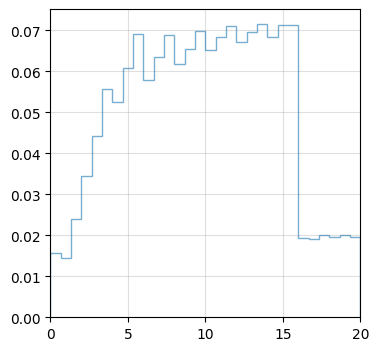

In [9]:
# visualize the data
import matplotlib.pyplot as plt
#unlensed_params = get_param_from_json("joint_new_optsnr.json")
test = np.array(unlensed_params['CE'])
test = test[test<20]
plt.figure(figsize=(4,4))
plt.hist(test, bins=30, alpha=0.6, histtype='step', density=True)
plt.xlim(0,20)
plt.grid(alpha=0.4)
plt.show()

In [10]:
len_ = len(unlensed_params['CE'])
idx = np.arange(len_)
# randomize the train set
idx = np.random.permutation(idx)
XCE,yCE = input_output(idx, unlensed_params, det='CE')
np.shape(XCE)

(410399, 5)

* It is expected to have larger error in the sparse region of the input data, e.g. $\eta<0.2$

## Scaling the data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(XCE, yCE, test_size = 0.1, random_state = 0)

# Uncomment the following if you have not generated the scaler

# feature scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# save the scaler
pickle.dump(sc, open('scalerCE_final.pkl', 'wb'))

# # Uncomment the following if you have already generated the scaler

# # load the scaler
# scalerCE = pickle.load(open('scalerCE_final.pkl', 'rb'))
# sc = scalerCE
# X_train = sc.transform(X_train)
# X_test = sc.transform(X_test)

### Generate ANN model

In [12]:
# Uncomment the following if you have already trained the model

# initialize the ANN
ann = tf.keras.models.Sequential() 

# adding the input layer and the first hidden layer
# units=5, where 5 is the number of neurons in the first input layer
ann.add(tf.keras.layers.Dense(units=5, activation='relu'))
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
# adding the third hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
# adding the output layer, absolute value of the snr
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))

# compile the ANN
ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

# train the ANN on the training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 100)

Epoch 1/100
11543/11543 ━━━━━━━━━━━━━━━━━━━━ 4s 338us/step - accuracy: 2.8348e-05 - loss: 206.3959
Epoch 2/100
11543/11543 ━━━━━━━━━━━━━━━━━━━━ 4s 338us/step - accuracy: 4.8802e-05 - loss: 22.7763
Epoch 3/100
11543/11543 ━━━━━━━━━━━━━━━━━━━━ 4s 336us/step - accuracy: 7.5912e-05 - loss: 22.1683
Epoch 4/100
11543/11543 ━━━━━━━━━━━━━━━━━━━━ 4s 333us/step - accuracy: 1.7834e-04 - loss: 20.6717
Epoch 5/100
11543/11543 ━━━━━━━━━━━━━━━━━━━━ 4s 331us/step - accuracy: 4.2073e-04 - loss: 17.6215
Epoch 6/100
11543/11543 ━━━━━━━━━━━━━━━━━━━━ 4s 332us/step - accuracy: 0.0010 - loss: 15.6144
Epoch 7/100
11543/11543 ━━━━━━━━━━━━━━━━━━━━ 4s 331us/step - accuracy: 0.0013 - loss: 13.9444
Epoch 8/100
11543/11543 ━━━━━━━━━━━━━━━━━━━━ 4s 348us/step - accuracy: 0.0013 - loss: 13.2510
Epoch 9/100
11543/11543 ━━━━━━━━━━━━━━━━━━━━ 4s 344us/step - accuracy: 0.0012 - loss: 12.4438
Epoch 10/100
11543/11543 ━━━━━━━━━━━━━━━━━━━━ 4s 331us/step - accuracy: 0.0015 - loss: 12.4318
Epoch 11/100
11543/11543 ━━━━━━━━━━━━━

In [13]:
# Uncomment the following if you have not trained the model

# Save the model to a file
ann.save('ann_modelCE_final.h5')
modelCE = ann

In [14]:
# # Uncomment the following if you have already generated the model

# # load the model
# from tensorflow.keras.models import load_model
# modelCE = load_model('ann_modelCE_final.h5')

### Test the Model on the test data

In [15]:
# left: predicted snr, right: actual snr
y_pred = modelCE.predict(X_test)
#y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[10:25])

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step
[[32.48160934 31.11833476]
 [92.42681122 95.8071961 ]
 [10.52207088 11.04964386]
 [24.75508499 25.27978004]
 [15.65638447 15.65752278]
 [11.23371792 12.68763442]
 [24.57857513 27.501648  ]
 [14.2031126  14.77427228]
 [57.5716095  56.46679716]
 [ 6.87845755  7.34805009]
 [10.63552475 10.98350598]
 [ 3.29822755  4.01694627]
 [ 6.60030556  6.75623732]
 [ 3.2122252   3.40469505]
 [ 3.96116114  4.43925636]]


In [16]:
# calculate the error
len1 = len(y_pred)
len2 = np.sum((y_pred.flatten()>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 4.36%


In [23]:
# calculate the error
len1 = len(y_pred)
len2 = np.sum((y_pred.flatten()>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 4.73%


In [17]:
# 5 param: 97.627%
# 4 param, without theta_jn: 98.536%
y_pred_ = y_pred
y_test_ = y_test
cm = confusion_matrix((y_test_>8), ((y_pred_)>8))
print(cm)
accuracy = accuracy_score((y_test_>8), (y_pred_>8))*100
print(f"Accuracy: {accuracy:.3f}%")

[[ 8901   816]
 [  972 30351]]
Accuracy: 95.643%


In [24]:
# 5 param: 97.627%
# 4 param, without theta_jn: 98.536%
y_pred_ = y_pred
y_test_ = y_test
cm = confusion_matrix((y_test_>8), ((y_pred_)>8))
print(cm)
accuracy = accuracy_score((y_test_>8), (y_pred_>8))*100
print(f"Accuracy: {accuracy:.3f}%")

[[ 8611  1173]
 [  767 30489]]
Accuracy: 95.273%


### Test with astrophysical parameters

In [18]:
# Get the data. This data is generated using `ler` package.
unlensed_params = get_param_from_json("ler_data/unlensed_param_testing_ETCE.json")
X_,Y_ = input_output(np.arange(len(unlensed_params['CE'])), unlensed_params, det='CE')
scalerCE = pickle.load(open('scalerCE_final.pkl', 'rb'))
X_ = scalerCE.transform(X_)

modelCE = load_model('ann_modelCE_final.h5')
y_pred_ = modelCE.predict(X_).flatten()
y_test_ = Y_
cm = confusion_matrix((y_test_>8), ((y_pred_)>8))
print(cm)
accuracy = accuracy_score((y_test_>8), (y_pred_>8))*100
print(f"Accuracy: {accuracy:.3f}%")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step
[[ 2963   290]
 [ 1528 45219]]
Accuracy: 96.364%


In [25]:
# Get the data. This data is generated using `ler` package.
unlensed_params = get_param_from_json("ler_data/unlensed_param_testing_ETCE.json")
X_,Y_ = input_output(np.arange(len(unlensed_params['CE'])), unlensed_params, det='CE')
scalerCE = pickle.load(open('scalerCE_final.pkl', 'rb'))
X_ = scalerCE.transform(X_)

modelCE = load_model('ann_modelCE_final.h5')
y_pred_ = modelCE.predict(X_).flatten()
y_test_ = Y_
cm = confusion_matrix((y_test_>8), ((y_pred_)>8))
print(cm)
accuracy = accuracy_score((y_test_>8), (y_pred_>8))*100
print(f"Accuracy: {accuracy:.3f}%")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
[[ 2828   425]
 [ 1066 45681]]
Accuracy: 97.018%


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


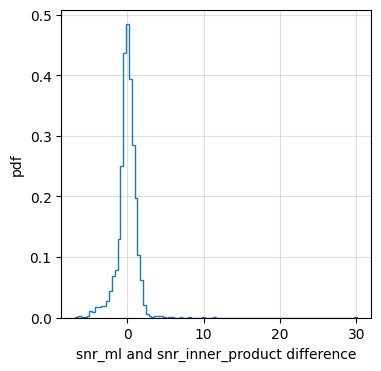

In [19]:
y_pred_ = modelCE.predict(X_).flatten()
y_test_ = Y_.copy()
# y_test = Y_
hist_ = y_pred_-y_test_
idx = (y_test_>6) & (y_test_<10)  # selection wrt snr
# idx = idx & (X_[:,2]>-2)  # selection wrt eta
hist_ = hist_[idx]
plt.figure(figsize=(4,4)) 
plt.hist(hist_, bins=100, histtype='step', density=True)
# plt.xlim(-5,5)
plt.xlabel('snr_ml and snr_inner_product difference')
plt.ylabel('pdf')
plt.grid(alpha=0.4)
plt.show()

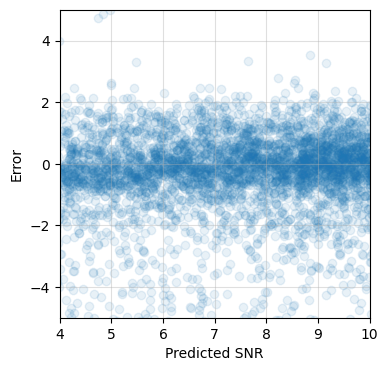

In [20]:
# idx = (y_pred_>4) & (y_pred_<12)
plt.figure(figsize=(4,4))
plt.scatter(y_pred_, y_pred_-y_test_, alpha=0.1)
plt.xlabel("Predicted SNR")
#plt.xscale("log")
plt.xlim(4,10)
plt.ylabel("Error")
plt.ylim(-5,5)
plt.grid(alpha=0.4)
plt.show()

### Error analysis

In [44]:
# Uncomment to create error ajustment

# do linear fitting of the error y_pred-y_test
def func(x, a, b):
    return a*x + b

idx = (y_pred_>7) & (y_pred_<9)
idx = idx & (y_test_!=0)
popt, pcov = curve_fit(func, y_pred_[idx], y_pred_[idx]-y_test_[idx])
print(f"slope: {popt[0]:.4f}, intercept: {popt[1]:.4f}")

try:
    adjustment_dict = load_json('error_adjustment_final.json')
except:
    adjustment_dict = {}
adjustment_dict['CE'] = {'slope': popt[0], 'intercept': popt[1]}
# save json
save_json('error_adjustment_final.json', adjustment_dict)

slope: 1.3145, intercept: -14.3267


In [45]:
# load json
adjustment_dict = load_json('error_adjustment_final.json')
a = adjustment_dict['CE']['slope']
b = adjustment_dict['CE']['intercept']

y_pred_ = modelCE.predict(X_).flatten()
y_pred_ = y_pred_-(a*y_pred_ + b)
y_test_ = Y_
cm = confusion_matrix((y_test_>8), ((y_pred_)>8))
print(cm)
accuracy = accuracy_score((y_test_>8), (y_pred_>8))*100
print(f"Accuracy (after error ajustment): {accuracy:.3f}%")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step
[[   56  3197]
 [33857 12890]]
Accuracy (after error ajustment): 25.892%


### Looking for the outliers

In [85]:
y_pred_ = modelCE.predict(X_).flatten()
y_test_ = Y_.copy()
# y_test = Y_
hist_ = abs(y_pred_-y_test_)
idx = (y_test_>6) & (y_test_<10)  # selection wrt snr
idx = idx & (hist_>3)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


In [86]:
unlensed_params = get_param_from_json("ler_data/unlensed_param_testing_ETCE.json")
selected_params = {}    
for key, value in unlensed_params.items():
    selected_params[key] = value[idx]

In [87]:
X_selected, y_selected = input_output(np.arange(len(selected_params['CE'])), selected_params, det='CE')
data_ = np.concatenate((X_selected, y_selected[:,None]), axis=1)

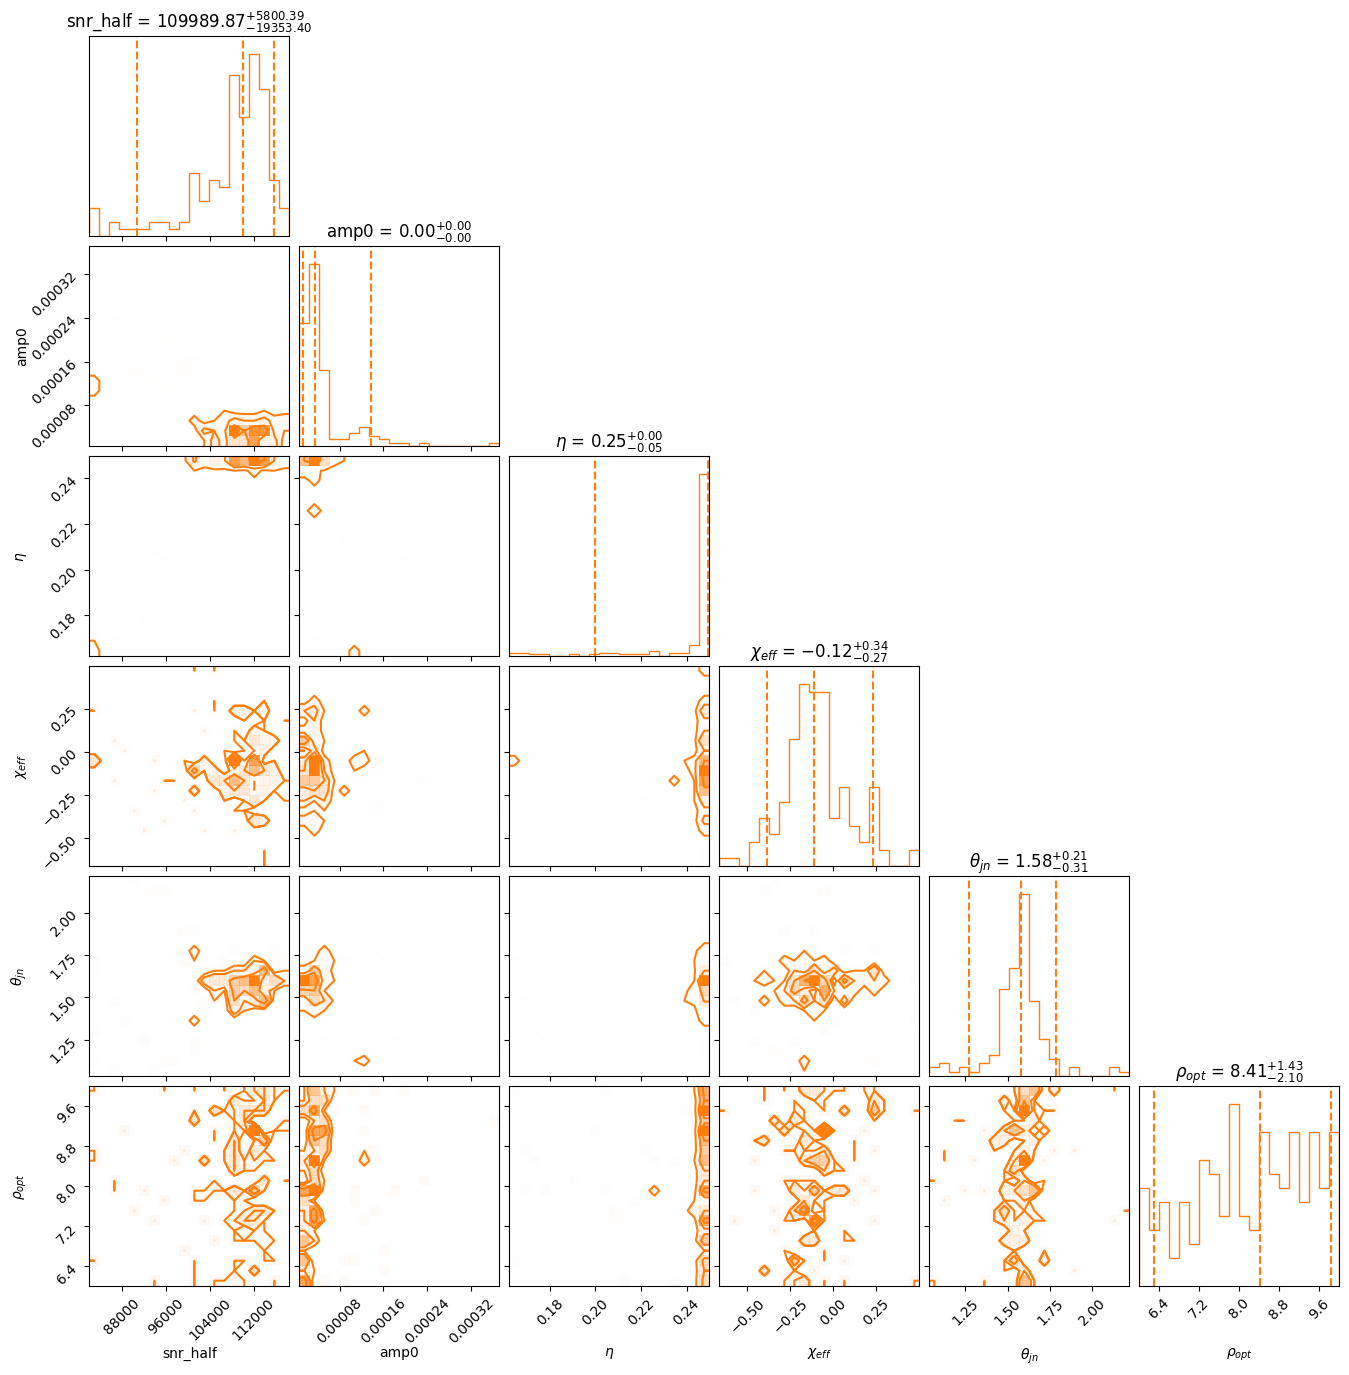

In [88]:
# corner plot
data_ = np.concatenate((X_selected, y_selected[:,None]), axis=1)
labels = [
    r"snr_half",
    r"amp0",
    r"$\eta$",
    r"$\chi_{eff}$",
    r"$\theta_{jn}$",
    r"$\rho_{opt}$",
]

fig = corner.corner(data_,color='C1',density=True, labels=labels, show_titles=True, plot_datapoints=False, quantiles=[0.05, 0.5, 0.95], hist_kwargs={'density':True})

plt.gcf()
plt.show()

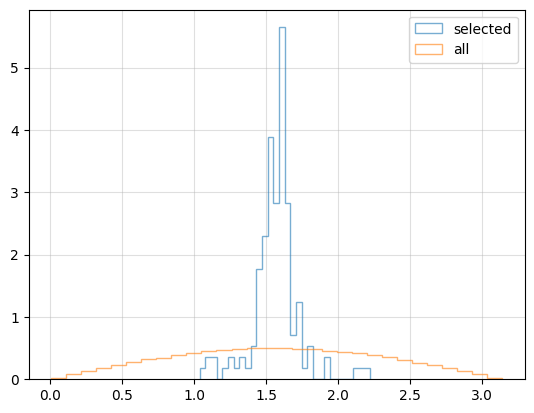

In [92]:
theta_jn = selected_params['theta_jn']
theta_jn2 = unlensed_params['theta_jn']
plt.hist(theta_jn, bins=30, alpha=0.6, histtype='step', density=True, label='selected')
plt.hist(theta_jn2, bins=30, alpha=0.6, histtype='step', density=True, label='all')
plt.legend()
plt.grid(alpha=0.4)
plt.show()

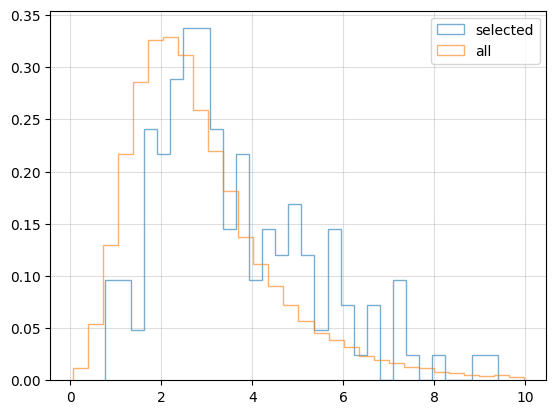

In [91]:
zs = selected_params['zs']
zs2 = unlensed_params['zs']
plt.hist(zs, bins=30, alpha=0.6, histtype='step', density=True, label='selected')
plt.hist(zs2, bins=30, alpha=0.6, histtype='step', density=True, label='all')
plt.grid(alpha=0.4)
plt.legend()
plt.show()